<a href="https://colab.research.google.com/github/muyuuuu/open-mmlab-colab/blob/main/mmdet_seesaw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 检查 torch 版本

In [1]:
import torch
torch.__version__

'1.8.1+cu101'


# 安装 MMdetection

In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html
     |████████████████████████████████| 31.2MB 94kB/s 
     |████████████████████████████████| 194kB 30.0MB/s 


In [3]:
!git clone https://github.com/muyuuuu/mmdetection.git

Cloning into 'mmdetection'...
remote: Enumerating objects: 17767, done.
remote: Total 17767 (delta 0), reused 0 (delta 0), pack-reused 17767
Receiving objects: 100% (17767/17767), 21.22 MiB | 31.85 MiB/s, done.
Resolving deltas: 100% (12376/12376), done.


In [4]:
%cd mmdetection
!pip install -r requirements/build.txt
!pip install -v -e .

/content/mmdetection
Created temporary directory: /tmp/pip-ephem-wheel-cache-i4z0hfgp
Created temporary directory: /tmp/pip-req-tracker-fgyviuts
Created requirements tracker '/tmp/pip-req-tracker-fgyviuts'
Created temporary directory: /tmp/pip-install-2pgb1etv
Obtaining file:///content/mmdetection
  Added file:///content/mmdetection to build tracker '/tmp/pip-req-tracker-fgyviuts'
    Running setup.py (path:/content/mmdetection/setup.py) egg_info for package from file:///content/mmdetection
    Running command python setup.py egg_info
    running egg_info
    creating mmdet.egg-info
    writing mmdet.egg-info/PKG-INFO
    writing dependency_links to mmdet.egg-info/dependency_links.txt
    writing requirements to mmdet.egg-info/requires.txt
    writing top-level names to mmdet.egg-info/top_level.txt
    writing manifest file 'mmdet.egg-info/SOURCES.txt'
    adding license file 'LICENSE' (matched pattern 'LICEN[CS]E*')
    reading manifest template 'MANIFEST.in'
    writing manifest file

# 验证

In [5]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


# 简单推理

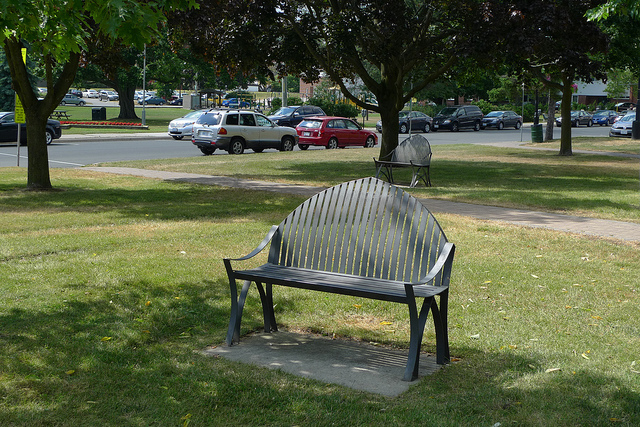

In [6]:
from PIL import Image
Image.open('demo/demo.jpg')

In [7]:
!mkdir checkpoints
!wget http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_2x_coco/faster_rcnn_r50_fpn_2x_coco_bbox_mAP-0.384_20200504_210434-a5d8aa15.pth -O checkpoints/model.pth

--2021-05-29 07:57:08--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_2x_coco/faster_rcnn_r50_fpn_2x_coco_bbox_mAP-0.384_20200504_210434-a5d8aa15.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167290877 (160M) [application/octet-stream]
Saving to: ‘checkpoints/model.pth’

checkpoints/model.p 100%[===================>] 159.54M  9.22MB/s    in 18s     

2021-05-29 07:57:27 (8.65 MB/s) - ‘checkpoints/model.pth’ saved [167290877/167290877]



# 对抗攻击尝试

## 生成 1 张图片，并保存为 COCO 格式

In [8]:
!rm -rf data/
!mkdir data
%cd data
!mkdir images
%cd ..
!cp demo/demo.jpg data/images/demo.jpg

/content/mmdetection/data
/content/mmdetection


In [10]:
import random
import json

# 目标检测配置文件
config_file = 'configs/faster_rcnn/faster_rcnn_r50_fpn_2x_coco.py'
# 训练模型
checkpoint_file = 'checkpoints/model.pth'

# 配置模型
model = init_detector(config=config_file,
                      checkpoint=checkpoint_file,
                      device='cuda:0')

img = 'demo/demo.jpg'
#  推理实际调用语句
results = inference_detector(model=model, imgs=img)

anno = {
    "images": [],
    "annotations": []
}

anno['categories'] = [
    {
        "id": 14,
        "name": "bench"
    },
    {
        "id": 3,
        "name": "car"
    }
]

image = {}
image['id'] = 1
image['width'] = 640
image['height'] = 427
image['file_name'] = 'demo.jpg'
anno['images'].append(image)

cnt = 0
for cate, result in enumerate(results, 1):
    for a in result:
        a = a.tolist()
        a = [float(i) for i in a]
        x, y, w, h = a[0], a[1], a[2] - a[0], a[3] - a[1]
        info = {}
        info['id'] = cnt
        cnt += 1
        info["image_id"] = 1
        info["category_id"] = cate
        info["bbox"] = [x, y, w, h]
        info["area"] = w * h
        info["iscrowd"] = 0
        info["segmentation"] = None

        anno['annotations'].append(info)


with open('data/train.json', 'w') as f:
    json.dump(anno, f, indent=4)

Use load_from_local loader


/content/mmdetection/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


In [16]:
!python tools/train.py \
    configs/faster_rcnn/faster_rcnn_r50_fpn_2x_coco.py \
    --no-validate

2021-05-29 08:05:22,085 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.10 (default, May  3 2021, 02:48:31) [GCC 7.5.0]
CUDA available: True
GPU 0: Tesla T4
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.0_bu.TC445_37.28845127_0
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.8.1+cu101
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v1.7.0 (Git Hash 7aed236906b1f7a05c0917e5257a1af05e9ff683)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70
  - CuDNN 7.6.3
  - Magma 2.5.2
  - Build settings: BLAS_INFO

In [ ]:
_base_ = [
    '../_base_/models/faster_rcnn_r50_fpn.py',
    '../_base_/datasets/coco_detection.py',
    '../_base_/schedules/schedule_2x.py', '../_base_/default_runtime.py'
]

# model settings
model = dict(
    type='FasterRCNN',
    pretrained='torchvision://resnet50',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[.0, .0, .0, .0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
    roi_head=dict(
        type='StandardRoIHead',
        bbox_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        bbox_head=dict(
            type='Shared2FCBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=80,
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0., 0., 0., 0.],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='SeesawLoss', num_classes=80,use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='L1Loss', loss_weight=1.0))),
    # model training and testing settings
    train_cfg=dict(
        rpn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.7,
                neg_iou_thr=0.3,
                min_pos_iou=0.3,
                match_low_quality=True,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=256,
                pos_fraction=0.5,
                neg_pos_ub=-1,
                add_gt_as_proposals=False),
            allowed_border=-1,
            pos_weight=-1,
            debug=False),
        rpn_proposal=dict(
            nms_pre=2000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0),
        rcnn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.5,
                neg_iou_thr=0.5,
                min_pos_iou=0.5,
                match_low_quality=False,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=512,
                pos_fraction=0.25,
                neg_pos_ub=-1,
                add_gt_as_proposals=True),
            pos_weight=-1,
            debug=False)),
    test_cfg=dict(
        rpn=dict(
            nms_pre=1000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0),
        rcnn=dict(
            score_thr=0.05,
            nms=dict(type='nms', iou_threshold=0.5),
            max_per_img=100)
        # soft-nms is also supported for rcnn testing
        # e.g., nms=dict(type='soft_nms', iou_threshold=0.5, min_score=0.05)
    ))

# dataset settings
dataset_type = 'CocoDataset'
data_root = ''
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]
data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type=dataset_type,
        ann_file=data_root + 'data/train.json',
        img_prefix=data_root + 'data/images/',
        pipeline=train_pipeline),
    val=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations/instances_val2017.json',
        img_prefix=data_root + 'val2017/',
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations/instances_val2017.json',
        img_prefix=data_root + 'val2017/',
        pipeline=test_pipeline))
evaluation = dict(interval=1, metric='bbox')

load_from = 'checkpoints/model.pth'
